# Data Cleaning and Feature Engineering

## Importing packages

In [1]:
#https://www.kaggle.com/code/thebendu/okcupid-profiles-data-analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import gensim.downloader as api
from tqdm import tqdm
import umap
from nltk.tokenize import word_tokenize
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/nina2012/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nina2012/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nina2012/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
!tree ..

..
├── README.md
├── notebooks
│   ├── Untitled.ipynb
│   ├── data_cleaning.ipynb
│   ├── dedemenezes_exploratory.ipynb
│   ├── exploratory_analysis.ipynb
│   └── training_model.ipynb
├── raw_data
│   ├── ok_clean.csv
│   ├── okcupid_profiles.csv
│   └── text_and_topics.csv
└── requirements.txt

3 directories, 10 files


## Loading the raw data

In [5]:
ok=pd.read_csv('../raw_data/okcupid_profiles.csv')

In [6]:
ok.iloc[:, 0:21]

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (..."
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++"
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no,"english, german (poorly)"
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no,english
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,NaN,NaN,socially,never,graduated from college/university,NaN,...,-1,sales / marketing / biz dev,2012-06-12-21-47,"oakland, california",has kids,has dogs,catholicism but not too serious about it,cancer and it&rsquo;s fun to think about,no,english
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,-1,entertainment / media,2012-06-29-11-01,"san francisco, california",doesn't have kids,likes dogs and likes cats,agnosticism,leo but it doesn&rsquo;t matter,no,english (fluently)
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,100000,construction / craftsmanship,2012-06-27-23-37,"south san francisco, california",doesn't have kids,NaN,christianity but not too serious about it,sagittarius but it doesn&rsquo;t matter,no,english (fluently)
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,-1,medicine / health,2012-06-23-13-01,"san francisco, california","doesn't have kids, but wants them",likes dogs and likes cats,agnosticism but not too serious about it,leo and it&rsquo;s fun to think about,trying to quit,"english (fluently), spanish (poorly), chinese ..."


In [7]:
# A function we will use often in this notebook
def pertentage_of_unique(data: pd.DataFrame, col: str):
    return round(data.groupby(col)[col].count().sort_values(ascending=False)*100/data.shape[0], 2)

## Replacing missing values and outliers; scaling

### Body type, drinks, drugs, job, smokes

In [8]:
def replace_nan(ok, column):
    ok[column] = ok[column].fillna("not_disclosed")  # Use fillna instead of replace
    return ok

In [9]:
for col in ["body_type", "drinks", "drugs", "job", "smokes"]:
    replace_nan(ok, col)

### Age

In [10]:
# Replacing the two values above 70 by the mode
ok.loc[ok["age"] >= 70, "age"] = ok["age"].mode()[0]

In [11]:
#For K-Means clustering, the best scaling method for age is Min-Max Scaling, because:
# K-Means is sensitive to feature magnitudes, so all features should be in a similar range.
# Min-Max ensures age is between 0 and 1, preventing it from dominating other features.
scaler = MinMaxScaler()
ok['age_scaled'] = scaler.fit_transform(ok[['age']])

### Height

In [12]:
# Replacing the missing heights with most frequent height
for sex in ok['sex'].unique():
    mode_height = ok.loc[ok['sex'] == sex, 'height'].mode()[0]
    ok.loc[ok['sex'] == sex, 'height'] = ok.loc[ok['sex'] == sex, 'height'].fillna(mode_height)

In [1]:
# Convert inches to meter
ok['height'] = ok['height'] * 2.54/100

NameError: name 'ok' is not defined

In [14]:
#Taking care of outliers (too short or to tall)

# Gender-specific bounds
lower_bound_male = 1.50
upper_bound_male = 2.10
lower_bound_female = 1.40
upper_bound_female = 2.00

for sex in ok['sex'].unique():
    if sex == 'm':
        lower_bound = lower_bound_male
        upper_bound = upper_bound_male
    else:
        lower_bound = lower_bound_female
        upper_bound = upper_bound_female

    mode_height = ok.loc[ok['sex'] == sex, 'height'].mode()[0]
    ok.loc[(ok['sex'] == sex) & ((ok['height'] < lower_bound) | (ok['height'] > upper_bound)), 'height'] = mode_height

In [15]:
# For height in your K-Means model, you should also use Min-Max Scaling, just like age.
# Reason: K-Means uses Euclidean distance, so all features should be in the same range to prevent one (like height) from dominating the clustering
scaler = MinMaxScaler()
ok['height_scaled'] = scaler.fit_transform(ok[['height']])

## Spliting into fields the following columns: Ethnicity, Location, Offspring, Pets, Religion, Sign, Diet, Education, Speaks (Language)

### Ethnicity

In [16]:
def split_ethnicity(ok):
    # Dictionary to store binary ethnicity columns
    cols = {}

    # Iterate through all unique values in the "ethnicity" column
    for e in ok["ethnicity"].unique():
        if isinstance(e, float):  # If it's NaN (float type), continue without processing
            continue  
        for et in e.split(", "):  # Split multi-ethnic values (e.g., "Asian, Hispanic")
            if et not in cols.keys():  # If the ethnicity is not already in the dictionary
                cols[et] = []  # Initialize an empty list for this ethnicity

    # List to store NaN status (1 if NaN, 0 otherwise)
    nan_status = []

    # Loop through the "ethnicity" column again to assign 1s and 0s
    for e in ok["ethnicity"]:
        is_nan = isinstance(e, float)  # Check if the value is NaN
        nan_status.append(1 if is_nan else 0)  # Append 1 for NaN, 0 otherwise

        trues = [] if is_nan else e.split(", ")  # If NaN, use an empty list
        for k in cols.keys():  # Iterate through all unique ethnicity categories
            val = 1 if k in trues else 0  # Assign 1 if the person has this ethnicity, otherwise 0
            cols[k].append(val)  # Append the value (1 or 0) to the corresponding list

    # Add the new binary columns to the DataFrame
    for k in cols.keys():
        tk = "is_" + k.replace(" ", "-")  # Format the column name (e.g., "is_Asian")
        ok[tk] = cols[k]  # Assign the binary list to the new column

    # Add the is_ethnicity_nan column to track missing values
    ok["is_ethnicity_nan"] = nan_status

    return ok  # Return the updated DataFrame

In [17]:
split_ethnicity(ok)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,is_asian,is_white,is_black,is_other,is_hispanic-/-latin,is_pacific-islander,is_native-american,is_middle-eastern,is_indian,is_ethnicity_nan
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,1,1,0,0,0,0,0,0,0,0
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,0,1,0,0,0,0,0,0,0,0
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,0,0,0,0,0,0,0,0,0,1
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,0,1,0,0,0,0,0,0,0,0
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,1,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,0,0,0,0,0,0,0,0,0,1
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,0,1,0,1,0,0,0,0,0,0
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,1,0,0,0,0,0,0,0,0,0
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,1,0,1,0,0,0,0,0,0,0


In [18]:
ethnicity_cols = ["is_asian", "is_white", "is_black", "is_other", "is_hispanic-/-latin", "is_pacific-islander",
             "is_native-american", "is_middle-eastern", "is_indian", "is_ethnicity_nan"]

In [19]:
columns = [0, 1]
print("{:<25} {:<10} {:<10}".format("ethnicity", "No", "Yes"))  # Print header
print("-" * 50)

for col in ethnicity_cols:
    per_data = pertentage_of_unique(ok, col)  # Get percentage data

    # Get values, defaulting to 0 if the key doesn't exist
    no_val = per_data.get(0, 0)
    yes_val = per_data.get(1, 0)

    # Print the row directly
    print(f"{col:<25} {no_val:<10} {yes_val:<10}")

ethnicity                 No         Yes       
--------------------------------------------------
is_asian                  86.31      13.69     
is_white                  36.81      63.19     
is_black                  94.45      5.55      
is_other                  94.05      5.95      
is_hispanic-/-latin       91.06      8.94      
is_pacific-islander       97.54      2.46      
is_native-american        97.89      2.11      
is_middle-eastern         98.42      1.58      
is_indian                 97.58      2.42      
is_ethnicity_nan          90.52      9.48      


### Location

In [20]:
def split_location(data):
    city = []
    state = []
    for e in ok["location"]:
        sp = e.split(", ")
        if len(sp) == 3:
            city.append(sp[0])
            state.append(sp[2])
        else:
            city.append(sp[0])
            state.append(sp[1])
    ok["city"] = city
    ok["state"] = state
    return ok

In [21]:
split_location(ok)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,is_black,is_other,is_hispanic-/-latin,is_pacific-islander,is_native-american,is_middle-eastern,is_indian,is_ethnicity_nan,city,state
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,0,0,0,0,0,0,0,0,south san francisco,california
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,0,0,0,0,0,0,0,0,oakland,california
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,0,0,0,0,0,0,0,1,san francisco,california
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,0,0,0,0,0,0,0,0,berkeley,california
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,1,1,0,0,0,0,0,0,san francisco,california
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,0,0,0,0,0,0,0,1,oakland,california
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,0,1,0,0,0,0,0,0,san francisco,california
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,0,0,0,0,0,0,0,0,south san francisco,california
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,1,0,0,0,0,0,0,0,san francisco,california


### Offspring

In [22]:
def split_offspring(data):
    not_disclosed = "not_disclosed"
    no_of_kids = []
    want_more_kids = []
    nofk_map = {
        "doesn't have kids": "zero",
        "has a kid": "one",
        "has kids": "more_than_one"
    }

    wmk_map = {
        "and doesn't want any": "no",
        "doesn't want kids": "no",
        "but doesn't want more": "no",
        "but might want them": "maybe",
        "and might want more": "maybe",
        "might want kids": "maybe",
        "but wants them": "yes",
        "and wants more": "yes",
        "wants kids": "yes"
    }

    for e in ok["offspring"]:
        if isinstance(e, float):
            no_of_kids.append(not_disclosed)
            want_more_kids.append(not_disclosed)
            continue
        sp = e.split(", ")
        if len(sp) == 2:
            no_of_kids.append(nofk_map[sp[0]])
            want_more_kids.append(wmk_map[sp[1]])
        else:
            if e in nofk_map.keys():
                no_of_kids.append(nofk_map[e])
                want_more_kids.append(not_disclosed)
            else:
                no_of_kids.append(not_disclosed)
                want_more_kids.append(wmk_map[e])
    ok["no_of_kids"] = no_of_kids
    ok["want_more_kids"] = want_more_kids
    return ok

In [23]:
split_offspring(ok)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,is_hispanic-/-latin,is_pacific-islander,is_native-american,is_middle-eastern,is_indian,is_ethnicity_nan,city,state,no_of_kids,want_more_kids
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,0,0,0,0,0,0,south san francisco,california,zero,maybe
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,0,0,0,0,0,0,oakland,california,zero,maybe
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,0,0,0,0,0,1,san francisco,california,not_disclosed,not_disclosed
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,0,0,0,0,0,0,berkeley,california,not_disclosed,no
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,0,0,0,0,0,0,san francisco,california,not_disclosed,not_disclosed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,0,0,0,0,0,1,oakland,california,more_than_one,not_disclosed
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,0,0,0,0,0,0,san francisco,california,zero,not_disclosed
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,0,0,0,0,0,0,south san francisco,california,zero,not_disclosed
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,0,0,0,0,0,0,san francisco,california,zero,yes


### Pets

In [24]:
def split_pets(data):
    nm = "not_disclosed"
    pet_map = {
        "dislikes cats": ("no", "no"),
        "dislikes dogs": ("no", "no"),
        "likes cats": ("not_disclosed", "yes"),
        "likes dogs": ("not_disclosed", "yes"),
        "has cats": ("yes", "yes"),
        "has dogs": ("yes", "yes")
    }
    has_dogs = []
    has_cats = []
    like_dogs = []
    like_cats = []
    for e in ok["pets"]:
        d_done = False
        c_done = False
        if not isinstance(e, float):
            for es in e.split(" and "):
                if es.find("cats") >= 0:
                    c_done = True
                    has_cats.append(pet_map[es][0])
                    like_cats.append(pet_map[es][1])
                else:
                    d_done = True
                    has_dogs.append(pet_map[es][0])
                    like_dogs.append(pet_map[es][1])
            
        if not c_done:
            has_cats.append(nm)
            like_cats.append(nm)
        if not d_done:
                has_dogs.append(nm)
                like_dogs.append(nm)
    ok["has_dogs"] = has_dogs
    ok["has_cats"] = has_cats
    ok["like_dogs"] = like_dogs
    ok["like_cats"] = like_cats
    return ok       

In [25]:
split_pets(ok)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,is_indian,is_ethnicity_nan,city,state,no_of_kids,want_more_kids,has_dogs,has_cats,like_dogs,like_cats
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,0,0,south san francisco,california,zero,maybe,not_disclosed,not_disclosed,yes,yes
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,0,0,oakland,california,zero,maybe,not_disclosed,not_disclosed,yes,yes
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,0,1,san francisco,california,not_disclosed,not_disclosed,not_disclosed,yes,not_disclosed,yes
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,0,0,berkeley,california,not_disclosed,no,not_disclosed,not_disclosed,not_disclosed,yes
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,0,0,san francisco,california,not_disclosed,not_disclosed,not_disclosed,not_disclosed,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,0,1,oakland,california,more_than_one,not_disclosed,yes,not_disclosed,yes,not_disclosed
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,0,0,san francisco,california,zero,not_disclosed,not_disclosed,not_disclosed,yes,yes
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,0,0,south san francisco,california,zero,not_disclosed,not_disclosed,not_disclosed,not_disclosed,not_disclosed
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,0,0,san francisco,california,zero,yes,not_disclosed,not_disclosed,yes,yes


### Religion

In [26]:
def split_religion(data):
    nm = "not_disclosed"
    seriouness_map = {"laughing about it": "laughing","not too serious about it": "not_much",
                      "somewhat serious about it": "somewhat", "very serious about it": "very"}
    religion_name = []
    religion_seriousness = []
    for e in ok["religion"]:
        if isinstance(e, float):
            religion_name.append(nm)
            religion_seriousness.append(nm)
            continue
        sp = re.split(" and | but ", e)
        if len(sp) == 1:
            religion_name.append(e)
            religion_seriousness.append(nm)
        else:
            religion_name.append(sp[0])
            religion_seriousness.append(seriouness_map[sp[1]])
    ok["religion_name"] = religion_name
    ok["religion_seriousness"] = religion_seriousness
    return ok

In [27]:
split_religion(ok)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,city,state,no_of_kids,want_more_kids,has_dogs,has_cats,like_dogs,like_cats,religion_name,religion_seriousness
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,south san francisco,california,zero,maybe,not_disclosed,not_disclosed,yes,yes,agnosticism,very
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,oakland,california,zero,maybe,not_disclosed,not_disclosed,yes,yes,agnosticism,not_much
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,san francisco,california,not_disclosed,not_disclosed,not_disclosed,yes,not_disclosed,yes,not_disclosed,not_disclosed
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,berkeley,california,not_disclosed,no,not_disclosed,not_disclosed,not_disclosed,yes,not_disclosed,not_disclosed
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,san francisco,california,not_disclosed,not_disclosed,not_disclosed,not_disclosed,yes,yes,not_disclosed,not_disclosed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,oakland,california,more_than_one,not_disclosed,yes,not_disclosed,yes,not_disclosed,catholicism,not_much
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,san francisco,california,zero,not_disclosed,not_disclosed,not_disclosed,yes,yes,agnosticism,not_disclosed
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,south san francisco,california,zero,not_disclosed,not_disclosed,not_disclosed,not_disclosed,not_disclosed,christianity,not_much
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,san francisco,california,zero,yes,not_disclosed,not_disclosed,yes,yes,agnosticism,not_much


### Sign

In [28]:
def split_sign(data):
    nm = "not_disclosed"
    seriouness_map = {"it doesn&rsquo;t matter": "no","it&rsquo;s fun to think about": "for_fun",
                      "it matters a lot": "very"}
    sign_name = []
    sign_seriousness = []
    for e in ok["sign"]:
        if isinstance(e, float):
            sign_name.append(nm)
            sign_seriousness.append(nm)
            continue
        sp = re.split(" and | but ", e)
        if len(sp) == 1:
            sign_name.append(e)
            sign_seriousness.append(nm)
        else:
            sign_name.append(sp[0])
            sign_seriousness.append(seriouness_map[sp[1]])
    ok["sign_name"] = sign_name
    ok["sign_seriousness"] = sign_seriousness
    return ok

In [29]:
split_sign(ok)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,no_of_kids,want_more_kids,has_dogs,has_cats,like_dogs,like_cats,religion_name,religion_seriousness,sign_name,sign_seriousness
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,zero,maybe,not_disclosed,not_disclosed,yes,yes,agnosticism,very,gemini,not_disclosed
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,zero,maybe,not_disclosed,not_disclosed,yes,yes,agnosticism,not_much,cancer,not_disclosed
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,not_disclosed,not_disclosed,not_disclosed,yes,not_disclosed,yes,not_disclosed,not_disclosed,pisces,no
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,not_disclosed,no,not_disclosed,not_disclosed,not_disclosed,yes,not_disclosed,not_disclosed,pisces,not_disclosed
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,not_disclosed,not_disclosed,not_disclosed,not_disclosed,yes,yes,not_disclosed,not_disclosed,aquarius,not_disclosed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,more_than_one,not_disclosed,yes,not_disclosed,yes,not_disclosed,catholicism,not_much,cancer,for_fun
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,zero,not_disclosed,not_disclosed,not_disclosed,yes,yes,agnosticism,not_disclosed,leo,no
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,zero,not_disclosed,not_disclosed,not_disclosed,not_disclosed,not_disclosed,christianity,not_much,sagittarius,no
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,zero,yes,not_disclosed,not_disclosed,yes,yes,agnosticism,not_much,leo,for_fun


### Diet

In [30]:
def split_diet(data):
    nm = "not_disclosed"
    diet_type = []
    diet_seriousness = []
    for e in ok["diet"]:
        if isinstance(e, float):
            diet_type.append(nm)
            diet_seriousness.append(nm)
            continue
        sp = e.split(" ")
        if len(sp) == 1:
            diet_type.append(e)
            diet_seriousness.append(nm)
        else:
            diet_type.append(sp[1])
            diet_seriousness.append(sp[0])
    ok["diet_type"] = diet_type
    ok["diet_seriousness"] = diet_seriousness
    return ok

In [31]:
split_diet(ok)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,has_dogs,has_cats,like_dogs,like_cats,religion_name,religion_seriousness,sign_name,sign_seriousness,diet_type,diet_seriousness
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,not_disclosed,not_disclosed,yes,yes,agnosticism,very,gemini,not_disclosed,anything,strictly
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,not_disclosed,not_disclosed,yes,yes,agnosticism,not_much,cancer,not_disclosed,other,mostly
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,not_disclosed,yes,not_disclosed,yes,not_disclosed,not_disclosed,pisces,no,anything,not_disclosed
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,not_disclosed,not_disclosed,not_disclosed,yes,not_disclosed,not_disclosed,pisces,not_disclosed,vegetarian,not_disclosed
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,not_disclosed,not_disclosed,yes,yes,not_disclosed,not_disclosed,aquarius,not_disclosed,not_disclosed,not_disclosed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,yes,not_disclosed,yes,not_disclosed,catholicism,not_much,cancer,for_fun,not_disclosed,not_disclosed
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,not_disclosed,not_disclosed,yes,yes,agnosticism,not_disclosed,leo,no,anything,mostly
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,not_disclosed,not_disclosed,not_disclosed,not_disclosed,christianity,not_much,sagittarius,no,anything,mostly
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,not_disclosed,not_disclosed,yes,yes,agnosticism,not_much,leo,for_fun,anything,mostly


### Education 

In [32]:
def split_education(data):
    nm = "not_disclosed"
    education_type = []
    education_status = []
    for e in ok["education"]:
        if isinstance(e, float):
            education_type.append(nm)
            education_status.append(nm)
            continue
        sp = re.split(" of | from | on ", e)
        if len(sp) == 1:
            education_type.append(e)
            education_status.append("working")
        else:
            education_type.append(sp[1])
            education_status.append(sp[0].replace(" ", "_"))
    ok["education_type"] = education_type
    ok["education_status"] = education_status
    return ok

In [33]:
split_education(ok)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,like_dogs,like_cats,religion_name,religion_seriousness,sign_name,sign_seriousness,diet_type,diet_seriousness,education_type,education_status
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,yes,yes,agnosticism,very,gemini,not_disclosed,anything,strictly,college/university,working
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,yes,yes,agnosticism,not_much,cancer,not_disclosed,other,mostly,space camp,working
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,not_disclosed,yes,not_disclosed,not_disclosed,pisces,no,anything,not_disclosed,masters program,graduated
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,not_disclosed,yes,not_disclosed,not_disclosed,pisces,not_disclosed,vegetarian,not_disclosed,college/university,working
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,yes,yes,not_disclosed,not_disclosed,aquarius,not_disclosed,not_disclosed,not_disclosed,college/university,graduated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,yes,not_disclosed,catholicism,not_much,cancer,for_fun,not_disclosed,not_disclosed,college/university,graduated
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,yes,yes,agnosticism,not_disclosed,leo,no,anything,mostly,college/university,working
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,not_disclosed,not_disclosed,christianity,not_much,sagittarius,no,anything,mostly,masters program,graduated
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,yes,yes,agnosticism,not_much,leo,for_fun,anything,mostly,college/university,working


### Sepaks (language)

In [34]:
def split_speaks(data):
    nm = "not_disclosed"
    fluency_map = {"fluently": "fluent", "poorly": "poor", "okay": "okay"}
    languages = {}
    for e in ok["speaks"].unique():
        if not isinstance(e, float):
            for l in e.split(", "):
                k = l.split(" ")[0]
                if k not in languages.keys():
                    languages[k] = []
    
    for e in ok["speaks"]:
        lang_map = {}
        blank_val = "none"
        if not isinstance(e, float):
            for f in e.split(", "):
                sp2 = f.split(" (")
                lang = sp2[0]
                fluency = "fluent"
                if len(sp2) == 2:
                    fluency = fluency_map[sp2[1][0:-1]]
                lang_map[lang] = fluency
        else:
            blank_val = nm
                
        for k in languages.keys():
            if k in lang_map.keys():
                languages[k].append(lang_map[k])
            else:
                languages[k].append(blank_val)
                
    for k in languages.keys():
        ok[k] = languages[k]
    return ok

In [35]:
split_speaks(ok)

/var/folders/2t/sm6lyf654rg6frtq76mrrpq00000gn/T/ipykernel_12019/1121297096.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ok[k] = languages[k]
/var/folders/2t/sm6lyf654rg6frtq76mrrpq00000gn/T/ipykernel_12019/1121297096.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ok[k] = languages[k]
/var/folders/2t/sm6lyf654rg6frtq76mrrpq00000gn/T/ipykernel_12019/1121297096.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,maori,frisian,chechen,slovenian,basque,mongolian,rotuman,slovak,armenian,sardinian
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,none,none,none,none,none,none,none,none,none,none
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,none,none,none,none,none,none,none,none,none,none
2,38,available,m,straight,thin,anything,socially,not_disclosed,graduated from masters program,NaN,...,none,none,none,none,none,none,none,none,none,none
3,23,single,m,straight,thin,vegetarian,socially,not_disclosed,working on college/university,white,...,none,none,none,none,none,none,none,none,none,none
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,none,none,none,none,none,none,none,none,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,not_disclosed,NaN,socially,never,graduated from college/university,NaN,...,none,none,none,none,none,none,none,none,none,none
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",...,none,none,none,none,none,none,none,none,none,none
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,...,none,none,none,none,none,none,none,none,none,none
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",...,none,none,none,none,none,none,none,none,none,none


## Reducing some of the categories

In [36]:
# check unique count of each field
line = []
uniq = ok.nunique()
for k in uniq.keys():
    txt = f"{k}: {uniq[k]}"
    if len(line) < 4:
        line.append(txt)
    else:
        print("\t".join(line))
        line.clear()
        line.append(txt)

age: 52	status: 5	sex: 2	orientation: 3
body_type: 13	diet: 18	drinks: 7	drugs: 4
education: 32	ethnicity: 217	height: 27	income: 13
job: 22	last_online: 30123	location: 199	offspring: 15
pets: 15	religion: 45	sign: 2	smokes: 6
speaks: 7647	essay0: 54347	essay1: 51516	essay2: 48625
essay3: 43520	essay4: 49257	essay5: 48961	essay6: 43583
essay7: 45548	essay8: 39323	essay9: 45440	age_scaled: 52
height_scaled: 27	is_asian: 2	is_white: 2	is_black: 2
is_other: 2	is_hispanic-/-latin: 2	is_pacific-islander: 2	is_native-american: 2
is_middle-eastern: 2	is_indian: 2	is_ethnicity_nan: 2	city: 198
state: 41	no_of_kids: 4	want_more_kids: 4	has_dogs: 3
has_cats: 3	like_dogs: 3	like_cats: 3	religion_name: 10
religion_seriousness: 5	sign_name: 13	sign_seriousness: 4	diet_type: 7
diet_seriousness: 3	education_type: 9	education_status: 4	english: 4
spanish: 5	french: 5	c++: 5	german: 5
chinese: 5	italian: 5	tagalog: 5	japanese: 5
other: 5	thai: 5	russian: 5	dutch: 5
lisp: 5	indonesian: 5	portuguese: 5	

In [37]:
ok.iloc[:,120:133]

,welsh,lithuanian,estonian,malay,ilongo,maori,frisian,chechen,slovenian,basque,mongolian,rotuman,slovak
0,none,none,none,none,none,none,none,none,none,none,none,none,none
1,none,none,none,none,none,none,none,none,none,none,none,none,none
2,none,none,none,none,none,none,none,none,none,none,none,none,none
3,none,none,none,none,none,none,none,none,none,none,none,none,none
4,none,none,none,none,none,none,none,none,none,none,none,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,none,none,none,none,none,none,none,none,none,none,none,none,none
59942,none,none,none,none,none,none,none,none,none,none,none,none,none
59943,none,none,none,none,none,none,none,none,none,none,none,none,none
59944,none,none,none,none,none,none,none,none,none,none,none,none,none


### Status

In [38]:
pertentage_of_unique(ok, "status")

status
single            92.91
seeing someone     3.44
available          3.11
married            0.52
unknown            0.02
Name: status, dtype: float64

In [39]:
ok['single'] = (ok['status'] == 'single').astype(int)

/var/folders/2t/sm6lyf654rg6frtq76mrrpq00000gn/T/ipykernel_12019/1342940983.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ok['single'] = (ok['status'] == 'single').astype(int)


In [40]:
pertentage_of_unique(ok, "single")

single
1    92.91
0     7.09
Name: single, dtype: float64

### Sex

In [41]:
pertentage_of_unique(ok, "sex")

sex
m    59.77
f    40.23
Name: sex, dtype: float64

In [42]:
ok["female"]=(ok["sex"]=='f').astype(int)

/var/folders/2t/sm6lyf654rg6frtq76mrrpq00000gn/T/ipykernel_12019/649540499.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ok["female"]=(ok["sex"]=='f').astype(int)


In [43]:
pertentage_of_unique(ok, "female")

female
0    59.77
1    40.23
Name: female, dtype: float64

### Orientation

In [44]:
pertentage_of_unique(ok, "orientation")

orientation
straight    86.09
gay          9.30
bisexual     4.62
Name: orientation, dtype: float64

In [45]:
# One-hot encode the 'orientation' column
ok = pd.get_dummies(ok, columns=['orientation'], dtype=int)

### Body Type

In [46]:
pertentage_of_unique(ok, "body_type")

body_type
average           24.44
fit               21.20
athletic          19.72
not_disclosed      8.83
thin               7.86
curvy              6.55
a little extra     4.39
skinny             2.96
full figured       1.68
overweight         0.74
jacked             0.70
used up            0.59
rather not say     0.33
Name: body_type, dtype: float64

In [47]:
category_map = {
    'skinny': 'thin',
    'thin': 'thin',
    'a little extra': 'other',
    'full figured': 'other',
    'overweight': 'other',
    'jacked': 'other',
    'used up': 'other',
    'rather not say': 'not_disclosed',  # Now grouped with not_disclosed
    'not_disclosed': 'not_disclosed'  # Ensure consistency
}

ok['body_type'] = ok['body_type'].replace(category_map)

In [48]:
pertentage_of_unique(ok, "body_type")

body_type
average          24.44
fit              21.20
athletic         19.72
thin             10.82
not_disclosed     9.16
other             8.10
curvy             6.55
Name: body_type, dtype: float64

In [49]:
# One-hot encode the 'body_type' column
ok = pd.get_dummies(ok, columns=['body_type'], dtype=int)

### Diet

In [50]:
diet_cols = ["diet_type", "diet_seriousness"]
for col in diet_cols:
    print(pertentage_of_unique(ok, col))
    print("------------------------------------")

diet_type
anything         46.51
not_disclosed    40.69
vegetarian        8.32
other             2.99
vegan             1.17
kosher            0.19
halal             0.13
Name: diet_type, dtype: float64
------------------------------------
diet_seriousness
not_disclosed    52.94
mostly           35.88
strictly         11.18
Name: diet_seriousness, dtype: float64
------------------------------------


In [51]:
ok['diet_type'] = ok['diet_type'].replace(['vegan', 'kosher', 'halal'], 'other')

In [52]:
ok = pd.get_dummies(ok, columns=['diet_type'], dtype=int)
ok = pd.get_dummies(ok, columns=['diet_seriousness'], dtype=int)

### Drinks

In [53]:
pertentage_of_unique(ok, "drinks")

drinks
socially         69.70
rarely            9.94
often             8.61
not at all        5.45
not_disclosed     4.98
very often        0.79
desperately       0.54
Name: drinks, dtype: float64

In [54]:
drinks_map = {
    'very often': 'often',
    'desperately': 'often',
    'often': 'often'
}

ok['drinks'] = ok['drinks'].replace(drinks_map)

In [55]:
pertentage_of_unique(ok, "drinks")

drinks
socially         69.70
often             9.94
rarely            9.94
not at all        5.45
not_disclosed     4.98
Name: drinks, dtype: float64

In [56]:
ok=pd.get_dummies(ok,columns=['drinks'], dtype=int)

### Drugs

In [57]:
pertentage_of_unique(ok, "drugs")

drugs
never            62.93
not_disclosed    23.49
sometimes        12.90
often             0.68
Name: drugs, dtype: float64

In [58]:
drugs_map = {
    'often': 'sometimes',
    'sometimes': 'sometimes'
}

ok['drugs'] = ok['drugs'].replace(drugs_map)

In [59]:
pertentage_of_unique(ok, "drugs")

drugs
never            62.93
not_disclosed    23.49
sometimes        13.58
Name: drugs, dtype: float64

In [60]:
ok=pd.get_dummies(ok,columns=['drugs'], dtype=int)

### Education

In [61]:
education_cols = ["education_type", "education_status"]
for col in education_cols:
    print(pertentage_of_unique(ok, col))
    print("------------------------------------")

education_type
college/university    52.49
masters program       18.22
not_disclosed         11.06
two-year college       5.03
ph.d program           4.02
high school            2.86
space camp             2.81
law school             2.38
med school             1.14
Name: education_type, dtype: float64
------------------------------------
education_status
graduated        65.69
working          19.74
not_disclosed    11.06
dropped_out       3.52
Name: education_status, dtype: float64
------------------------------------


In [62]:
education_map = {
    'masters program': 'grad_or_professional_edu',
    'ph.d program': 'grad_or_professional_edu',
    'law school': 'grad_or_professional_edu',
    'med school': 'grad_or_professional_edu',
    'college/university': 'college_univ',
    'two-year college': 'two_year_college_or_less',
    'high school': 'two_year_college_or_less',
    'space camp': 'two_year_college_or_less',
    'not_disclosed': 'not_disclosed'
}

ok['education_type'] = ok['education_type'].replace(education_map)

In [63]:
# Define the correct education order
edu_order = [
    "not_disclosed",  
    "two_year_college_or_less",  
    "college_univ",  
    "grad_or_professional_edu"
]

# Convert to categorical
ok['education_type'] = pd.Categorical(ok['education_type'], categories=edu_order, ordered=True)

# Shift 'dropped_out' individuals to the previous category if needed
def update_education(row):
    if row['education_status'] == 'dropped_out' and row['education_type'] in ["college_univ", "grad_or_professional_edu"]:
        current_index = edu_order.index(row['education_type'])
        return edu_order[current_index - 1]  # Move to the previous category
    return row['education_type']

# Apply the function
ok['education_type'] = ok.apply(update_education, axis=1)

In [64]:
# Aggregate 'dropped_out' with 'not_disclosed'
ok['education_status'] = ok['education_status'].replace('dropped_out', 'not_disclosed')

In [65]:
for col in education_cols:
    print(pertentage_of_unique(ok, col))
    print("------------------------------------")

education_type
college_univ                51.33
grad_or_professional_edu    25.26
two_year_college_or_less    12.36
not_disclosed               11.06
Name: education_type, dtype: float64
------------------------------------
education_status
graduated        65.69
working          19.74
not_disclosed    14.57
Name: education_status, dtype: float64
------------------------------------


In [66]:
# Cross-tabulation of education_type and education_status
crosstab_result = pd.crosstab(ok['education_type'], ok['education_status'])

# Display the result
print(crosstab_result)

education_status          graduated  not_disclosed  working
education_type                                             
college_univ                  23959            297     6513
grad_or_professional_edu      11801              0     3339
not_disclosed                     0           6628        0
two_year_college_or_less       3616           1811     1982


In [67]:
# One-hot encode the 'body_type' column
ok = pd.get_dummies(ok, columns=['education_type'], dtype=int)
ok = pd.get_dummies(ok, columns=['education_status'], dtype=int)

### Income

In [68]:
pertentage_of_unique(ok, "income")

income
-1          80.81
 20000       4.92
 100000      2.70
 80000       1.85
 30000       1.75
 40000       1.68
 50000       1.63
 60000       1.23
 70000       1.18
 150000      1.05
 1000000     0.87
 250000      0.25
 500000      0.08
Name: income, dtype: float64

In [69]:
ok['income_reported'] = (ok['income'] != -1).astype(int)

In [70]:
pertentage_of_unique(ok, "income_reported")

income_reported
0    80.81
1    19.19
Name: income_reported, dtype: float64

### Job

In [71]:
pertentage_of_unique(ok, "job")

job
not_disclosed                        13.68
other                                12.66
student                               8.14
science / tech / engineering          8.09
computer / hardware / software        7.86
artistic / musical / writer           7.40
sales / marketing / biz dev           7.32
medicine / health                     6.14
education / academia                  5.86
executive / management                3.96
banking / financial / real estate     3.78
entertainment / media                 3.75
law / legal services                  2.30
hospitality / travel                  2.28
construction / craftsmanship          1.70
clerical / administrative             1.34
political / government                1.18
rather not say                        0.73
transportation                        0.61
unemployed                            0.46
retired                               0.42
military                              0.34
Name: job, dtype: float64

In [72]:
# Define categories that are considered non-paying jobs
non_paying_categories = ["not_disclosed", "student", "rather not say", "unemployed", "retired"]

# Create the new variable
ok["non_paying_job"] = ok["job"].isin(non_paying_categories).astype(int)

In [73]:
#New Job Categories
# Not Disclosed → not_disclosed, rather not say
# Student → student
# STEM & Business → science / tech / engineering, computer / hardware / software, sales / marketing / biz dev, executive / management, banking / financial / real estate
# Creative & Education → artistic / musical / writer, entertainment / media, education / academia
# Healthcare & Law → medicine / health, law / legal services, political / government
# Trades & Service → hospitality / travel, clerical / administrative, construction / craftsmanship, transportation, military
# Unemployed/Retired/Other → unemployed, retired, other

In [74]:
job_mapping = {
    "not_disclosed": "not_disclosed",
    "rather not say": "not_disclosed",
    
    "student": "student",
    
    "science / tech / engineering": "stem_business",
    "computer / hardware / software": "stem_business",
    "sales / marketing / biz dev": "stem_business",
    "executive / management": "stem_business",
    "banking / financial / real estate": "stem_business",
    
    "artistic / musical / writer": "creative_education",
    "entertainment / media": "creative_education",
    "education / academia": "creative_education",
    
    "medicine / health": "healthcare_law",
    "law / legal services": "healthcare_law",
    "political / government": "healthcare_law",
    
    "hospitality / travel": "trades_service",
    "clerical / administrative": "trades_service",
    "construction / craftsmanship": "trades_service",
    "transportation": "trades_service",
    "military": "trades_service",
    
    "unemployed": "unemployed_retired_other",
    "retired": "unemployed_retired_other",
    "other": "unemployed_retired_other"
}


# Apply mapping to the DataFrame
ok["job_grouped"] = ok["job"].map(job_mapping)

In [75]:
pertentage_of_unique(ok, "job_grouped")

job_grouped
stem_business               31.01
creative_education          17.02
not_disclosed               14.40
unemployed_retired_other    13.53
healthcare_law               9.62
student                      8.14
trades_service               6.27
Name: job_grouped, dtype: float64

In [76]:
ok = ok.rename(columns={'job': 'job_original'})

In [77]:
ok = ok.rename(columns={'job_grouped': 'job'})

In [78]:
ok=pd.get_dummies(ok,columns=["job"], dtype=int)

### Smokes

In [79]:
pertentage_of_unique(ok, "smokes")

smokes
no                73.23
not_disclosed      9.19
sometimes          6.32
when drinking      5.07
yes                3.72
trying to quit     2.47
Name: smokes, dtype: float64

In [80]:
smokes_mapping = {
    "sometimes": "yes",
    "when drinking": "yes",
    "trying to quit": "yes"
}

# Apply the mapping
ok["smokes"] = ok["smokes"].replace(smokes_mapping)

In [81]:
pertentage_of_unique(ok, "smokes")

smokes
no               73.23
yes              17.58
not_disclosed     9.19
Name: smokes, dtype: float64

In [82]:
ok=pd.get_dummies(ok,columns=["smokes"], dtype=int)

### Ethnicity

In [83]:
ethnicity_cols = ["is_asian", "is_white", "is_black", "is_other", "is_hispanic-/-latin", "is_pacific-islander",
             "is_native-american", "is_middle-eastern", "is_indian", "is_ethnicity_nan"]

In [84]:
columns = [0, 1]
print("{:<25} {:<10} {:<10}".format("ethnicity", "No", "Yes"))  # Print header
print("-" * 50)

for col in ethnicity_cols:
    per_data = pertentage_of_unique(ok, col)  # Get percentage data

    # Get values, defaulting to 0 if the key doesn't exist
    no_val = per_data.get(0, 0)
    yes_val = per_data.get(1, 0)

    # Print the row directly
    print(f"{col:<25} {no_val:<10} {yes_val:<10}")

ethnicity                 No         Yes       
--------------------------------------------------
is_asian                  86.31      13.69     
is_white                  36.81      63.19     
is_black                  94.45      5.55      
is_other                  94.05      5.95      
is_hispanic-/-latin       91.06      8.94      
is_pacific-islander       97.54      2.46      
is_native-american        97.89      2.11      
is_middle-eastern         98.42      1.58      
is_indian                 97.58      2.42      
is_ethnicity_nan          90.52      9.48      


In [85]:
# Excluding is_ethinicity_nan for further analysis
ethnicity_cols = ["is_asian", "is_white", "is_black", "is_other", "is_hispanic-/-latin", "is_pacific-islander",
             "is_native-american", "is_middle-eastern", "is_indian"]

In [86]:
ok["ethnicity_count"] = ok[ethnicity_cols].sum(axis=1)

In [87]:
pertentage_of_unique(ok, "ethnicity_count")

ethnicity_count
1    79.08
0     9.48
2     9.03
3     1.75
4     0.39
9     0.11
5     0.09
6     0.03
8     0.02
7     0.02
Name: ethnicity_count, dtype: float64

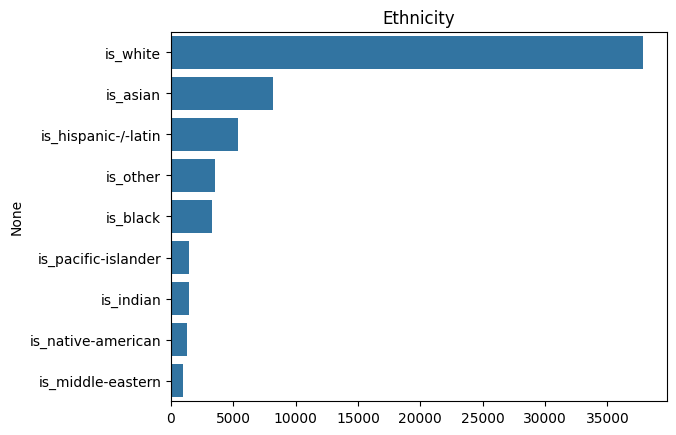

In [88]:
ethnicity_count = ok[ethnicity_cols].sum()
sns.barplot(x=ethnicity_count.values, y=ethnicity_count.index, order=ethnicity_count.sort_values(ascending=False).index)
plt.title("Ethnicity")
plt.show()

In [89]:
# Merge specified ethnicity columns into "is_other"
ok["is_other"] += ok["is_pacific-islander"] + ok["is_native-american"] + ok["is_middle-eastern"] + ok["is_indian"]

# Drop the merged columns
ok.drop(columns=["is_pacific-islander", "is_native-american", "is_middle-eastern", "is_indian"], inplace=True)

In [90]:
ethnicity_cols = ["is_asian", "is_white", "is_black", "is_other", "is_hispanic-/-latin", "is_ethnicity_nan"]

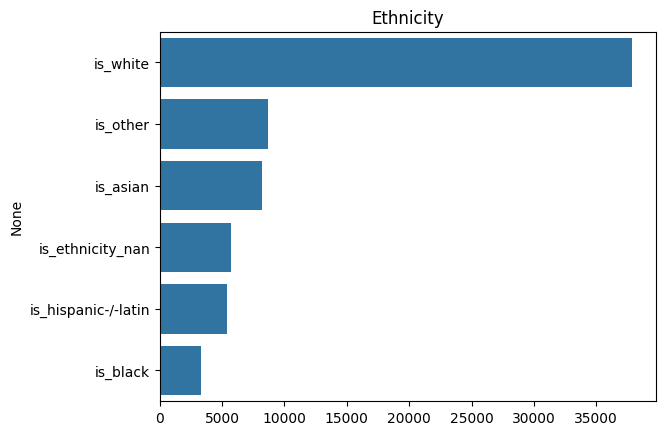

In [91]:
ethnicity_count = ok[ethnicity_cols].sum()
sns.barplot(x=ethnicity_count.values, y=ethnicity_count.index, order=ethnicity_count.sort_values(ascending=False).index)
plt.title("Ethnicity")
plt.show()

In [92]:
ok = ok.rename(columns={'is_hispanic-/-latin': 'is_hispanic_latin'})

In [93]:
# Get the list of columns
cols = list(ok.columns)

# Move 'ethnicity_count' to be right after 'is_ethnicity_nan'
if 'ethnicity_count' in cols and 'is_ethnicity_nan' in cols:
    cols.insert(cols.index('is_ethnicity_nan') + 1, cols.pop(cols.index('ethnicity_count')))

# Reorder the dataframe
ok = ok[cols]

### Location

In [94]:
# Let's not use state in the analysis, as most of it is CA (98,85).
# We could maybe use city or only use it as a final filter.
# Think if we will add geolocation

In [95]:
location_cols = ["city", "state"]
for col in location_cols:
    print(pertentage_of_unique(ok, col))
    print("------------------------------------")

city
san francisco    51.82
oakland          12.03
berkeley          7.03
san mateo         2.22
palo alto         1.77
                 ...  
nevada city       0.00
murfreesboro      0.00
muir beach        0.00
cork              0.00
milpitas          0.00
Name: city, Length: 198, dtype: float64
------------------------------------
state
california              99.85
new york                 0.03
illinois                 0.01
massachusetts            0.01
oregon                   0.01
michigan                 0.01
texas                    0.01
arizona                  0.01
florida                  0.01
virginia                 0.00
district of columbia     0.00
spain                    0.00
colorado                 0.00
hawaii                   0.00
washington               0.00
minnesota                0.00
ohio                     0.00
utah                     0.00
georgia                  0.00
united kingdom           0.00
tennessee                0.00
switzerland              0.00

In [96]:
cities_per_state = ok[location_cols].groupby("state").count()

In [97]:
cities_per_state[cities_per_state['city'] > 2].sort_values(by="city", ascending=False)

,city
state,
california,59855
new york,17
illinois,8
massachusetts,5
michigan,4
oregon,4
texas,4
arizona,3
florida,3


### Offspring

In [98]:
# Too many missing values, think if we want to keep this feature

In [99]:
offspring_cols = ["no_of_kids", "want_more_kids"]

In [100]:
for col in offspring_cols:
    print(pertentage_of_unique(ok, col))
    print("------------------------------------")

no_of_kids
not_disclosed    64.88
zero             26.91
more_than_one     4.11
one               4.10
Name: no_of_kids, dtype: float64
------------------------------------
want_more_kids
not_disclosed    78.21
no                7.97
maybe             7.34
yes               6.48
Name: want_more_kids, dtype: float64
------------------------------------


In [101]:
pd.crosstab(ok['no_of_kids'], ok['want_more_kids'])

want_more_kids,maybe,no,not_disclosed,yes
no_of_kids,,,,
more_than_one,115,442,1883,21
not_disclosed,182,2927,35561,225
one,231,275,1881,71
zero,3875,1132,7560,3565


In [102]:
ok=pd.get_dummies(ok, columns=["no_of_kids"], dtype=int)

In [103]:
ok=pd.get_dummies(ok, columns=['want_more_kids'], dtype=int)

### Pets

In [104]:
pets_cols = ["has_dogs", "like_dogs", "has_cats", "like_cats"]
for col in pets_cols:
    print(pertentage_of_unique(ok, col))
    print("------------------------------------")

has_dogs
not_disclosed    84.90
yes              14.17
no                0.94
Name: has_dogs, dtype: float64
------------------------------------
like_dogs
yes              61.51
not_disclosed    37.55
no                0.94
Name: like_dogs, dtype: float64
------------------------------------
has_cats
not_disclosed    83.03
yes              12.13
no                4.84
Name: has_cats, dtype: float64
------------------------------------
like_cats
not_disclosed    52.25
yes              42.91
no                4.84
Name: like_cats, dtype: float64
------------------------------------


In [105]:
ok = pd.get_dummies(ok, columns=pets_cols, dtype=int)

### Religion

In [106]:
religion_cols = ["religion_name", "religion_seriousness"]
for col in religion_cols:
    print(pertentage_of_unique(ok, col))
    print("------------------------------------")

religion_name
not_disclosed    33.74
agnosticism      14.70
other            12.92
atheism          11.65
christianity      9.65
catholicism       7.94
judaism           5.17
buddhism          3.25
hinduism          0.75
islam             0.23
Name: religion_name, dtype: float64
------------------------------------
religion_seriousness
not_disclosed    53.39
not_much         20.37
laughing         15.01
somewhat          7.53
very              3.70
Name: religion_seriousness, dtype: float64
------------------------------------


In [107]:
ok['religion_name'] = ok['religion_name'].replace(
    ['hinduism', 'buddhism', 'islam', 'other'], 'other')

In [108]:
pertentage_of_unique(ok, 'religion_name')

religion_name
not_disclosed    33.74
other            17.15
agnosticism      14.70
atheism          11.65
christianity      9.65
catholicism       7.94
judaism           5.17
Name: religion_name, dtype: float64

In [109]:
pd.crosstab(ok["religion_name"], ok["religion_seriousness"])

religion_seriousness,laughing,not_disclosed,not_much,somewhat,very
religion_name,,,,,
agnosticism,2496,2724,2636,642,314
atheism,2074,2175,1318,848,570
catholicism,726,1064,2318,548,102
christianity,373,1957,1952,927,578
judaism,681,612,1517,266,22
not_disclosed,0,20226,0,0,0
other,2645,3249,2471,1285,630


In [110]:
ok = ok.rename(columns={'religion': 'religion_original'})
ok = ok.rename(columns={'religion_name': 'religion'})

In [111]:
ok = pd.get_dummies(ok, columns=['religion', 'religion_seriousness'], dtype=int)

### Sign

In [112]:
sign_cols = ["sign_name", "sign_seriousness"]
for col in sign_cols:
    print(pertentage_of_unique(ok, col))
    print("------------------------------------")

sign_name
not_disclosed    18.44
leo               7.30
gemini            7.19
libra             7.02
cancer            7.02
virgo             6.91
taurus            6.91
scorpio           6.90
aries             6.65
pisces            6.58
sagittarius       6.58
aquarius          6.55
capricorn         5.96
Name: sign_name, dtype: float64
------------------------------------
sign_seriousness
not_disclosed    38.67
for_fun          32.25
no               27.96
very              1.13
Name: sign_seriousness, dtype: float64
------------------------------------


In [113]:
ok['sign_seriousness'] = ok['sign_seriousness'].replace('very', 'for_fun')

In [114]:
pd.crosstab(ok["sign_name"], ok['sign_seriousness'])

sign_seriousness,for_fun,no,not_disclosed
sign_name,,,
aquarius,1566,1408,954
aries,1620,1373,996
cancer,1660,1454,1092
capricorn,1421,1319,833
gemini,1844,1453,1013
leo,1758,1457,1159
libra,1701,1408,1098
not_disclosed,0,0,11056
pisces,1654,1300,992


In [115]:
ok=ok.rename(columns={'sign': 'sign_original'})
ok=ok.rename(columns={'sign_name': 'sign'})

In [116]:
ok=pd.get_dummies(ok,columns=['sign','sign_seriousness'], dtype=int)

### Speaks

In [117]:
speaks_cols = ['english', 'spanish', 'french', 'c++', 'german', 'chinese', 'italian', 'tagalog', 'japanese', 'other', 'thai', 'russian', 'dutch', 'lisp', 'indonesian', 'portuguese', 'swedish', 'belarusan', 'gujarati', 'farsi', 'hindi', 'sanskrit', 'afrikaans', 'khmer', 'hebrew', 'yiddish', 'polish', 'serbian', 'korean', 'persian', 'czech', 'croatian', 'bengali', 'vietnamese', 'esperanto', 'swahili', 'latin', 'norwegian', 'greek', 'ancient', 'albanian', 'icelandic', 'arabic', 'tibetan', 'cebuano', 'georgian', 'hawaiian', 'turkish', 'latvian', 'tamil', 'bulgarian', 'ukrainian', 'occitan', 'breton', 'catalan', 'urdu', 'danish', 'hungarian', 'irish', 'romanian', 'finnish', 'welsh', 'lithuanian', 'estonian', 'malay', 'ilongo', 'maori', 'frisian', 'chechen', 'slovenian', 'basque', 'mongolian', 'rotuman', 'slovak', 'armenian', 'sardinian']
#for col in speaks_cols:
#    print(pertentage_of_unique(ok, col))
#    print("------------------------------------")

In [118]:
# Recode poor and not mentioned as none, and okay and fluent as yes

# Define the recoding rules
recode_rules = {
    'fluent': 'yes',
    'okay': 'yes',
    'poor': 'none',
    'not_disclosed': 'none'
}

# Apply the recoding to each language column
for lang in speaks_cols:
    ok[lang] = ok[lang].replace(recode_rules)

In [119]:
# Replacing none by zero and yes by 1
replace_rules = {
    'none': 0,
    'yes': 1
}
for lang in speaks_cols:
    ok[lang] = ok[lang].replace(replace_rules)

/var/folders/2t/sm6lyf654rg6frtq76mrrpq00000gn/T/ipykernel_12019/4283145079.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ok[lang] = ok[lang].replace(replace_rules)


In [120]:
# We will now create a coulumn with the number of languaes the person speaks (flunetly and ok)
ok['speaks_count'] = ok[speaks_cols].sum(axis=1)

In [121]:
pertentage_of_unique(ok, 'speaks_count')

speaks_count
1    61.89
2    27.53
3     7.40
4     1.83
0     0.84
5     0.50
Name: speaks_count, dtype: float64

In [122]:
# List of all language columns except 'english' and 'spanish'
other_languages = [lang for lang in speaks_cols if lang not in ['english', 'spanish']]

# Create the `speaks_other` variable
ok['speaks_other'] = (ok[other_languages].sum(axis=1) > 0).astype(int)

# Now `ok` will have a new column `speaks_other`

In [123]:
# List of language columns to drop (all languages except 'english' and 'spanish')
columns_to_drop = [lang for lang in speaks_cols if lang not in ['english', 'spanish']]

# Drop the unnecessary language columns
ok = ok.drop(columns=[col for col in columns_to_drop if col in ok.columns])

# Now `ok` will have all original columns except the dropped language columns

In [124]:
ok = ok.rename(columns={'english': 'speaks_english'})
ok = ok.rename(columns={'spanish': 'speaks_spanish'})

### Organizing the Data Frame

In [125]:
# Get the list of columns
cols = list(ok.columns)

# Move 'speaks_other' and 'speaks_count' to be right after 'speaks_spanish'
for col in ['speaks_count', 'speaks_other']:
    if col in cols:
        cols.insert(cols.index('speaks_spanish') + 1, cols.pop(cols.index(col)))

# Reorder the dataframe
ok = ok[cols]

In [126]:
desired_order = [
    'age', 'status', 'sex', 'diet', 'education', 'ethnicity', 'height', 'income', 'job_original', 'last_online', 
    'location', 'offspring', 'pets', 'religion_original', 'sign_original', 'speaks', 'essay0', 'essay1', 'essay2', 
    'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'age_scaled', 'single', 'female', 
    'orientation_bisexual', 'orientation_gay', 'orientation_straight', 'body_type_athletic', 'body_type_average', 
    'body_type_curvy', 'body_type_fit', 'body_type_not_disclosed', 'body_type_other', 'body_type_thin', 
    'diet_type_anything', 'diet_type_not_disclosed', 'diet_type_other', 'diet_type_vegetarian', 'diet_seriousness_mostly', 
    'diet_seriousness_not_disclosed', 'diet_seriousness_strictly', 'drinks_not at all', 'drinks_not_disclosed', 
    'drinks_often', 'drinks_rarely', 'drinks_socially', 'drugs_never', 'drugs_not_disclosed', 'drugs_sometimes', 
    'education_type_college_univ', 'education_type_grad_or_professional_edu', 'education_type_not_disclosed', 
    'education_type_two_year_college_or_less', 'education_status_graduated', 'education_status_not_disclosed', 
    'education_status_working', 'is_asian', 'is_white', 'is_black', 'is_other', 'is_hispanic_latin', 'is_ethnicity_nan', 
    'ethnicity_count', 'height_scaled', 'income_reported', 'non_paying_job', 'job_creative_education', 'job_healthcare_law', 
    'job_not_disclosed', 'job_stem_business', 'job_student', 'job_trades_service', 'job_unemployed_retired_other', 'city', 
    'state', 'no_of_kids_more_than_one', 'no_of_kids_not_disclosed', 'no_of_kids_one', 'no_of_kids_zero', 'want_more_kids_maybe', 
    'want_more_kids_no', 'want_more_kids_not_disclosed', 'want_more_kids_yes', 'has_dogs_no', 'has_dogs_not_disclosed', 
    'has_dogs_yes', 'like_dogs_no', 'like_dogs_not_disclosed', 'like_dogs_yes', 'has_cats_no', 'has_cats_not_disclosed', 
    'has_cats_yes', 'like_cats_no', 'like_cats_not_disclosed', 'like_cats_yes', 'religion_agnosticism', 'religion_atheism', 
    'religion_catholicism', 'religion_christianity', 'religion_judaism', 'religion_not_disclosed', 'religion_other', 
    'religion_seriousness_laughing', 'religion_seriousness_not_disclosed', 'religion_seriousness_not_much', 
    'religion_seriousness_somewhat', 'religion_seriousness_very', 'sign_aquarius', 'sign_aries', 'sign_cancer', 'sign_capricorn', 
    'sign_gemini', 'sign_leo', 'sign_libra', 'sign_not_disclosed', 'sign_pisces', 'sign_sagittarius', 'sign_scorpio', 
    'sign_taurus', 'sign_virgo', 'sign_seriousness_for_fun', 'sign_seriousness_no', 'sign_seriousness_not_disclosed', 'smokes_no', 
    'smokes_not_disclosed', 'smokes_yes', 'speaks_english', 'speaks_spanish', 'speaks_other', 'speaks_count'
]

# Identify columns that are not in the desired order list
remaining_columns = [col for col in ok.columns if col not in desired_order]

# Create the final column order by appending the remaining columns to the desired order
final_order = desired_order + remaining_columns

# Reorder DataFrame
ok = ok[final_order]

In [127]:
# Our initial vector X with features will be (109 features)
x=ok.iloc[:,26:]

In [128]:
x

,age_scaled,single,female,orientation_bisexual,orientation_gay,orientation_straight,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,...,sign_seriousness_for_fun,sign_seriousness_no,sign_seriousness_not_disclosed,smokes_no,smokes_not_disclosed,smokes_yes,speaks_english,speaks_spanish,speaks_other,speaks_count
0,0.078431,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,0.333333,1,0,0,0,1,0,1,0,0,...,0,0,1,1,0,0,1,0,0,1
2,0.392157,0,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,1,3
3,0.098039,1,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1
4,0.215686,1,0,0,0,1,1,0,0,0,...,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,0.803922,1,1,0,0,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
59942,0.117647,1,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1
59943,0.470588,1,0,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,0,1
59944,0.176471,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,1,1,0,0,1


In [129]:
ok.iloc[:,0:26]

,age,status,sex,diet,education,ethnicity,height,income,job_original,last_online,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,strictly anything,working on college/university,"asian, white",1.9050,-1,transportation,2012-06-28-20-30,...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,mostly other,working on space camp,white,1.7780,80000,hospitality / travel,2012-06-29-21-41,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,anything,graduated from masters program,NaN,1.7272,-1,not_disclosed,2012-06-27-09-10,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,vegetarian,working on college/university,white,1.8034,20000,student,2012-06-28-14-22,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,NaN,graduated from college/university,"asian, black, other",1.6764,-1,artistic / musical / writer,2012-06-27-21-26,...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,NaN,graduated from college/university,NaN,1.5748,-1,sales / marketing / biz dev,2012-06-12-21-47,...,"vibrant, expressive, caring optimist. i love b...",the happiest times have been when life came to...,i make an outstanding osso bucco. i am also ve...,"i am told that people notice my smile, eyes an...",i am an avid movie watcher and follow the broa...,"my family, my dog, italy, words and music!",writing my book.,"running with my dog, finishing up the work wee...",i have a dream to sing at the alconquin in nyc...,you are seeking a long term connection of shar...
59942,24,single,m,mostly anything,working on college/university,"white, other",1.8288,-1,entertainment / media,2012-06-29-11-01,...,i'm nick. i never know what to write about mys...,currently finishing school for film production...,"filmmaking, photography, graphic design, web d...","dude, i don't know.","movies: hook (the greatest adventure ever!), g...",iphone contact lenses headphones camera tv rem...,i do most of my thinking on the bus to/from wo...,"bringin' home bacon, or drinking and shakin'!",when i was 18 i got a tattoo of waldo somewher...,meh if you made it this far you might as well.
59943,42,single,m,mostly anything,graduated from masters program,asian,1.8034,100000,construction / craftsmanship,2012-06-27-23-37,...,"hello! i enjoy traveling, watching movies, and...","i'm a civil engineer, who enjoys helping 

In [130]:
# check unique count of each field
line = []
uniq = ok.nunique()
for k in uniq.keys():
    txt = f"{k}: {uniq[k]}"
    if len(line) < 4:
        line.append(txt)
    else:
        print("\t".join(line))
        line.clear()
        line.append(txt)

age: 52	status: 5	sex: 2	diet: 18
education: 32	ethnicity: 217	height: 27	income: 13
job_original: 22	last_online: 30123	location: 199	offspring: 15
pets: 15	religion_original: 45	sign_original: 2	speaks: 7647
essay0: 54347	essay1: 51516	essay2: 48625	essay3: 43520
essay4: 49257	essay5: 48961	essay6: 43583	essay7: 45548
essay8: 39323	essay9: 45440	age_scaled: 52	single: 2
female: 2	orientation_bisexual: 2	orientation_gay: 2	orientation_straight: 2
body_type_athletic: 2	body_type_average: 2	body_type_curvy: 2	body_type_fit: 2
body_type_not_disclosed: 2	body_type_other: 2	body_type_thin: 2	diet_type_anything: 2
diet_type_not_disclosed: 2	diet_type_other: 2	diet_type_vegetarian: 2	diet_seriousness_mostly: 2
diet_seriousness_not_disclosed: 2	diet_seriousness_strictly: 2	drinks_not at all: 2	drinks_not_disclosed: 2
drinks_often: 2	drinks_rarely: 2	drinks_socially: 2	drugs_never: 2
drugs_not_disclosed: 2	drugs_sometimes: 2	education_type_college_univ: 2	education_type_grad_or_professional_ed

## Cleaning and Vectorizing essay columns

### Cleaning text

In [131]:
# Create one single column with essay
essay_columns = ['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 
                 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']

# Combine all essay text columns into a single column named "essays"
ok['essays'] = ok[essay_columns].astype(str).fillna('').agg(' '.join, axis=1)

In [132]:
def basic_cleaning(sentence):
    # Basic cleaning
    sentence = sentence.strip() # remove whitespaces
    sentence = sentence.lower() # lowercase
    sentence = ''.join(char for char in sentence if not char.isdigit()) # remove numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')
        
    return sentence

In [133]:
%%time
# Apply the basic_cleaning function to the 'essays' column and create a new 'essay_clean' column
ok['essay_clean'] = ok['essays'].apply(basic_cleaning)
ok['essay_clean']

CPU times: user 6.69 s, sys: 47.3 ms, total: 6.74 s
Wall time: 6.75 s


0        about me  i would love to think that i was som...
1        i am a chef this is what that means  i am a wo...
2        im not ashamed of much but writing public text...
3        i work in a library and go to school   reading...
4        hey hows it going currently vague on the profi...
                               ...                        
59941    vibrant expressive caring optimist i love bein...
59942    im nick i never know what to write about mysel...
59943    hello i enjoy traveling watching movies and ha...
59944    all i have in this world are my balls and my i...
59945    is it odd that having a little enemy status wi...
Name: essay_clean, Length: 59946, dtype: object

### Tokenization and Lemmatization

In [134]:
# Function created by Dedé (dedemenezes_exploratory.ipynb notebook)
def basic_preprocessing(sentence):
    tokenized_sentence = word_tokenize(sentence) ## tokenize
    stop_words = set(stopwords.words('english')) ## define stopwords

    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v")
        for word in tokenized_sentence_cleaned
    ]

    # 2 - Lemmatizing the nouns
    noun_lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "n")
        for word in lemmatized
    ]
    
    cleaned_sentence = ' '.join(word for word in noun_lemmatized)
    return cleaned_sentence

In [135]:
%%time
ok['essay_toke_lemma'] = ok['essay_clean'].apply(basic_preprocessing)

CPU times: user 1min 26s, sys: 654 ms, total: 1min 26s
Wall time: 1min 27s


In [136]:
ok['essay_toke_lemma']

0        would love think kind intellectual either dumb...
1        chef mean workaholic love cook regardless whet...
2        im ashamed much write public text online date ...
3        work library go school read thing write old de...
4        hey hows go currently vague profile know come ...
                               ...                        
59941    vibrant expressive care optimist love people t...
59942    im nick never know write im sure hand im south...
59943    hello enjoy travel watch movie hang friend rul...
59944    world ball integrity one take either away momm...
59945    odd little enemy status someone make seem inte...
Name: essay_toke_lemma, Length: 59946, dtype: object

### New columns on text lenght and text answered

In [137]:
text_df=ok.iloc[:, 17:26]

In [138]:
ok['text_answered_percent'] = (100-(text_df.apply(lambda x: x.isna().sum() / len(text_df.columns) * 100, axis=1)))/100

In [139]:
ok['text_length'] = ok.essay_toke_lemma.str.len()

In [140]:
ok['text_length'].describe()

count    59946.000000
mean      1308.121593
std       1073.661356
min          0.000000
25%        589.000000
50%       1096.000000
75%       1761.000000
max      44638.000000
Name: text_length, dtype: float64

In [141]:
# Standard deviation (1073.66) is relatively high compared to the mean (1308.12), 
# indicating significant variability in the data.
# So let's clip outliers and use the min max scaler

# Clip values above the 99th percentile
upper_threshold = ok['text_length'].quantile(0.99)
ok['text_length_clipped'] = ok['text_length'].clip(upper=upper_threshold)

scaler = MinMaxScaler()
ok['text_length_scaled'] = scaler.fit_transform(ok[['text_length_clipped']])

print(ok[['text_length', 'text_length_clipped', 'text_length_scaled']].describe())

        text_length  text_length_clipped  text_length_scaled
count  59946.000000         59946.000000        59946.000000
mean    1308.121593          1291.480149            0.260550
std     1073.661356           968.820170            0.195455
min        0.000000             0.000000            0.000000
25%      589.000000           589.000000            0.118828
50%     1096.000000          1096.000000            0.221113
75%     1761.000000          1761.000000            0.355273
max    44638.000000          4956.750000            1.000000


In [142]:
ok['text_length_scaled'].describe()

count    59946.000000
mean         0.260550
std          0.195455
min          0.000000
25%          0.118828
50%          0.221113
75%          0.355273
max          1.000000
Name: text_length_scaled, dtype: float64

In [143]:
# Correlating the two variables:
ok['text_length_scaled'].corr(ok['text_answered_percent'])

0.48082622015160925

### Using vectorizer TfidfVectorizer

In [144]:
%%time
# Convert text data to numerical features using TF-IDF

# Instantiating the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

X_vect = pd.DataFrame(vectorizer.fit_transform(ok['essay_toke_lemma'].values).toarray(),
                 columns = vectorizer.get_feature_names_out())

CPU times: user 4.55 s, sys: 87.2 ms, total: 4.64 s
Wall time: 4.64 s


In [145]:
X_vect.shape

(59946, 1000)

### Use Truncated SVD for Dimensionality Reduction

In [146]:
# Perform SVD first to reduce dimensionality (e.g., to 100 components)
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = pd.DataFrame(svd.fit_transform(X_vect))

### Word Embeddings

In [147]:
word2vec_model = api.load("word2vec-google-news-300")

# Check the model's vocabulary
print("Vocabulary size:", len(word2vec_model.key_to_index))

Vocabulary size: 3000000


In [148]:
# Function to get the average word2vec vector for a given essay
def get_average_word2vec(tokens, model, vector_size=300):
    vectors = []
    for word in tokens:
        if word in model.key_to_index:
            vectors.append(model[word])
    if len(vectors) == 0:
        # If no words found in the model, return a zero vector
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Apply the function to get the average word2vec vector for each essay
ok['word2vec_embeddings'] = ok['essay_toke_lemma'].apply(lambda x: get_average_word2vec(x, word2vec_model))

In [149]:
# Convert word2vec embeddings column into a DataFrame with separate columns
word2vec_features = pd.DataFrame(ok['word2vec_embeddings'].to_list(), 
                                 columns=[f'word2vec_{i}' for i in range(300)])

### PCA

In [150]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

def apply_pca_and_update_dataset(X, n_components=2, dataset=None, pca_column_prefix="PCA"):
    """
    Apply PCA on the given feature matrix and add the components to the dataset.
    
    Parameters:
    - X: The feature matrix (e.g., TF-IDF matrix or any other feature vectors).
    - n_components: Number of PCA components to retain (default is 2).
    - dataset: The original dataset (default is `None` which means it will use `ok`).
    - pca_column_prefix: The prefix for the PCA column names (default is "PCA").
    
    Returns:
    - None (updates the dataset in-place).
    """
    if dataset is None:
        dataset = ok
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Convert PCA results into a DataFrame
    pca_df = pd.DataFrame(X_pca, columns=[f'{pca_column_prefix}_{i+1}' for i in range(n_components)])

    # Add PCA components back to the original dataset (in-place)
    for col in pca_df.columns:
        dataset[col] = pca_df[col]

    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print("Explained variance by each principal component:", explained_variance)

    # Display the first few rows of the PCA components in the dataset
    print(dataset[[f'{pca_column_prefix}_{i+1}' for i in range(n_components)]].head())

    # Plotting the PCA results (for 2 components)
    if n_components == 2:
        plt.scatter(dataset[f'{pca_column_prefix}_1'], dataset[f'{pca_column_prefix}_2'], alpha=0.5)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('PCA Projection')
        plt.show()

#### PCA - using the vectors

Explained variance by each principal component: [0.09394409 0.01242478]
   PCA_vect_1  PCA_vect_2
0   -0.159428   -0.000456
1    0.096556   -0.023418
2   -0.158735    0.082767
3    0.238496   -0.047104
4    0.264132   -0.015653


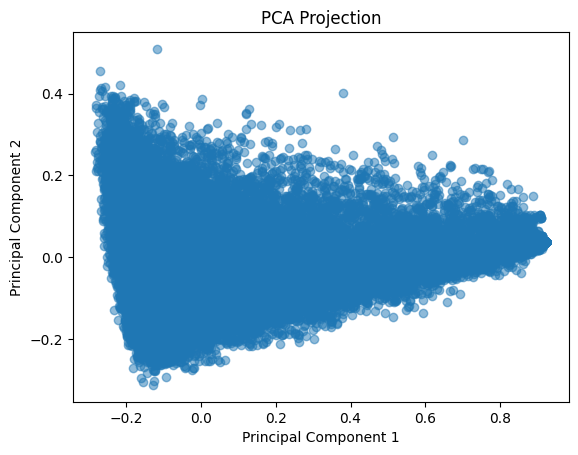

In [151]:
apply_pca_and_update_dataset(X_vect, n_components=2, dataset=None, pca_column_prefix="PCA_vect")

#### PCA - using the Truncated SVD 

Explained variance by each principal component: [0.26576669 0.03512799]
   PCA_sdv_1  PCA_sdv_2
0  -0.159439   0.000766
1   0.096552  -0.023299
2  -0.158735   0.082745
3   0.238498  -0.046735
4   0.264136  -0.016103


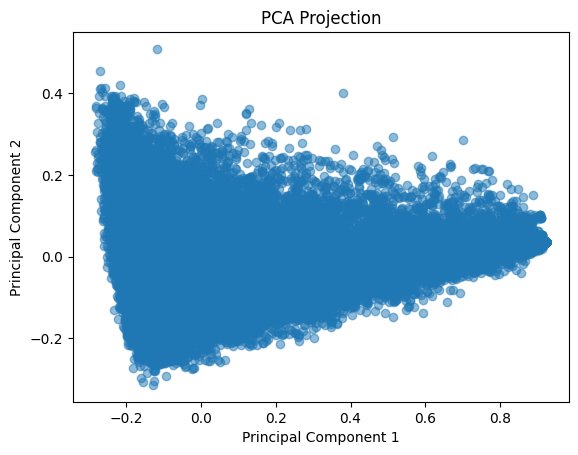

In [152]:
apply_pca_and_update_dataset(X_svd, n_components=2, dataset=None, pca_column_prefix="PCA_sdv")

#### PCA - using Word Embeddings

Explained variance by each principal component: [0.91895267 0.01726238]
   PCA_emb_1  PCA_emb_2
0  -0.099448   0.002080
1  -0.051667   0.003022
2  -0.091794   0.001104
3  -0.050622   0.058900
4  -0.051213   0.031173


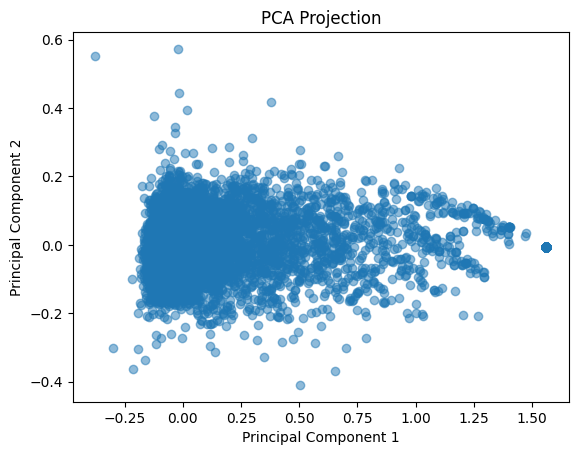

In [153]:
apply_pca_and_update_dataset(word2vec_features, n_components=2, dataset=None, pca_column_prefix="PCA_emb")

### LDA (Dedé) 

#### LDA 5 topics

In [154]:
%%time
# Instantiate the LDA
n_components = 5
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 100)

# Fit the LDA on the vectorized documents
lda_model.fit(X_vect)

CPU times: user 14min 1s, sys: 925 ms, total: 14min 2s
Wall time: 14min 2s


LatentDirichletAllocation(max_iter=100, n_components=5)

In [155]:
document_topic_mixture = lda_model.transform(X_vect)

In [156]:
document_topic_mixture

array([[0.0206227 , 0.02079322, 0.02066511, 0.02004141, 0.91787757],
       [0.02524981, 0.88296384, 0.02526485, 0.04138808, 0.02513341],
       [0.01619333, 0.01614862, 0.01633676, 0.01799468, 0.93332661],
       ...,
       [0.91650032, 0.02115607, 0.02099884, 0.02038103, 0.02096374],
       [0.02207642, 0.55197096, 0.02213225, 0.02139339, 0.38242698],
       [0.0194305 , 0.01949618, 0.0195413 , 0.01893136, 0.92260066]])

In [157]:
topics_df = pd.DataFrame({
    'topic_0': document_topic_mixture[:, 0],
    'topic_1': document_topic_mixture[:, 1],
    'topic_2': document_topic_mixture[:, 2],
    'topic_3': document_topic_mixture[:, 3],
    'topic_4': document_topic_mixture[:, 4],
})

In [158]:
ok = pd.concat([ok, topics_df], axis=1)

In [159]:
topic_means = topics_df.mean()
print(topic_means)

topic_0    0.230321
topic_1    0.168329
topic_2    0.211808
topic_3    0.065661
topic_4    0.323881
dtype: float64


In [160]:
topic_word_mixture = pd.DataFrame(
    lda_model.components_,
    columns = vectorizer.get_feature_names_out()
)

topic_word_mixture

,ability,able,absolutely,accent,act,action,active,activity,actually,add,...,year,yes,yoga,york,youd,youll,young,youre,youve,zombie
0,35.784854,70.752313,66.638603,94.975235,28.689724,52.666782,224.191971,171.862754,120.485994,36.717920,...,571.615331,95.804404,147.869998,116.354190,56.844018,68.415102,63.477316,246.313950,42.378556,17.238427
1,17.064400,47.359823,23.398600,22.818160,35.633288,111.274567,60.979103,39.327241,70.975930,26.693782,...,186.430753,59.584465,9.006671,7.619821,29.781747,64.712765,61.520321,156.889788,18.172217,19.129253
2,84.262562,122.439707,45.437105,55.509809,70.358033,76.162833,171.304969,156.625882,104.553771,64.986055,...,341.798173,114.098855,229.074618,45.578330,55.445931,71.911873,94.359355,226.040234,51.671904,5.014139
3,0.200950,0.201519,0.202062,0.203522,0.201471,0.201037,0.202166,0.201943,0.201462,0.202431,...,0.202427,0.201767,0.202353,0.201730,0.202446,0.203491,0.204723,0.204835,0.201546,0.201748
4,90.587526,127.817214,95.867216,95.343246,126.529529,89.022120,60.537381,89.713294,354.846324,107.751444,...,533.224512,265.776438,89.240919,89.586453,133.433430,139.240380,165.350200,612.579539,162.462043,161.552947


In [161]:
topic_word_mixture.iloc[0].sort_values(ascending = False).head(10)

im        1344.088224
love      1080.821515
friend     993.733827
like       903.853927
new        868.293675
work       845.294258
good       767.588907
food       713.856757
enjoy      712.841458
music      709.658989
Name: 0, dtype: float64

In [162]:
topic_word_mixture.iloc[1].sort_values(ascending = False).head(10)

im        1271.883462
love       816.514471
like       771.069008
friend     707.926706
good       594.443299
work       577.675473
people     510.355882
family     499.256466
time       497.326482
life       493.991222
Name: 1, dtype: float64

In [163]:
topic_word_mixture.iloc[2].sort_values(ascending = False).head(10)

love      1230.440181
im        1116.493313
life       927.206136
like       862.176992
good       767.058484
friend     751.177553
people     701.038049
enjoy      697.647347
thing      655.961149
time       649.776927
Name: 2, dtype: float64

In [164]:
topic_word_mixture.iloc[3].sort_values(ascending = False).head(10)

nan        7609.108112
soon         18.146669
ask          10.610511
hi           10.280691
profile       4.823436
check         4.490973
later         3.809568
update        3.276851
come          2.623003
ill           0.206923
Name: 3, dtype: float64

In [165]:
topic_word_mixture.iloc[4].sort_values(ascending = False).head(10)

im        2500.779806
like      1738.884561
thing     1152.195899
love      1146.453469
music     1111.978756
make      1095.504528
dont      1043.866212
people    1024.915846
good       986.416033
think      958.155625
Name: 4, dtype: float64

#### LDA 2 topics

In [166]:
%%time
# Instantiate the LDA
n_components = 2
lda_model2 = LatentDirichletAllocation(n_components=n_components, max_iter = 100)

# Fit the LDA on the vectorized documents
lda_model2.fit(X_vect)

CPU times: user 9min 29s, sys: 122 ms, total: 9min 29s
Wall time: 9min 30s


LatentDirichletAllocation(max_iter=100, n_components=2)

In [167]:
document_topic_mixture2 = lda_model.transform(X_vect)

In [168]:
topics_df2 = pd.DataFrame({
    'topic2_0': document_topic_mixture2[:, 0],
    'topic2_1': document_topic_mixture2[:, 1],
})

In [169]:
ok = pd.concat([ok, topics_df2], axis=1)

In [170]:
ok

,age,status,sex,diet,education,ethnicity,height,income,job_original,last_online,...,PCA_sdv_2,PCA_emb_1,PCA_emb_2,topic_0,topic_1,topic_2,topic_3,topic_4,topic2_0,topic2_1
0,22,single,m,strictly anything,working on college/university,"asian, white",1.9050,-1,transportation,2012-06-28-20-30,...,0.000766,-0.099448,0.002080,0.020623,0.020793,0.020665,0.020041,0.917878,0.020623,0.020793
1,35,single,m,mostly other,working on space camp,white,1.7780,80000,hospitality / travel,2012-06-29-21-41,...,-0.023299,-0.051667,0.003022,0.025250,0.882964,0.025265,0.041388,0.025133,0.025250,0.882964
2,38,available,m,anything,graduated from masters program,NaN,1.7272,-1,not_disclosed,2012-06-27-09-10,...,0.082745,-0.091794,0.001104,0.016193,0.016149,0.016337,0.017995,0.933327,0.016193,0.016149
3,23,single,m,vegetarian,working on college/university,white,1.8034,20000,student,2012-06-28-14-22,...,-0.046735,-0.050622,0.058900,0.037168,0.037057,0.037326,0.094012,0.794437,0.037168,0.037057
4,29,single,m,NaN,graduated from college/university,"asian, black, other",1.6764,-1,artistic / musical / writer,2012-06-27-21-26,...,-0.016103,-0.051213,0.031173,0.030121,0.030319,0.030293,0.091301,0.817966,0.030121,0.030319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,NaN,graduated from college/university,NaN,1.5748,-1,sales / marketing / biz dev,2012-06-12-21-47,...,-0.166816,-0.093428,-0.024569,0.021818,0.021712,0.913512,0.021138,0.021821,0.021818,0.021712
59942,24,single,m,mostly anything,working on college/university,"white, other",1.8288,-1,entertainment / media,2012-06-29-11-01,...,0.088082,-0.083126,0.017852,0.021163,0.021130,0.021041,0.020575,0.916091,0.021163,0.021130
59943,42,single,m,mostly anything,graduated from masters program,asian,1.8034,100000,construction / craftsmanship,2012-06-27-23-37,...,-0.130053,-0.071538,-0.019189,0.916500,0.021156,0.020999,0.020381,0.020964,0.916500,0.021156
59944,27,single,m,mostly anything,working on college/university,"asian, black",1.8542,-1,medicine / health,2012-06-23-13-01,...,-0.114143,-0.089618,-0.015810,0.022076,0.551971,0.022132,0.021393,0.382427,0.022076,0.551971


In [171]:
topic_means = topics_df2.mean()
print(topic_means)

topic2_0    0.230321
topic2_1    0.168329
dtype: float64


In [172]:
topic_word_mixture2 = pd.DataFrame(
    lda_model2.components_,
    columns = vectorizer.get_feature_names_out()
)

topic_word_mixture2

,ability,able,absolutely,accent,act,action,active,activity,actually,add,...,year,yes,yoga,york,youd,youll,young,youre,youve,zombie
0,226.888980,354.437381,181.242150,140.903327,260.397920,155.723240,77.837618,176.534559,647.458636,235.182829,...,919.691624,533.634398,358.344765,143.097884,256.690031,278.704243,322.558335,1123.475454,274.105857,202.321721
1,1.011312,14.133197,50.301436,127.946645,1.014126,173.604098,439.377971,281.196556,3.604846,1.168803,...,713.579572,1.831531,117.049794,116.242639,19.017540,65.779367,62.353580,118.552891,0.780409,0.814793


In [173]:
topic_word_mixture2.iloc[0].sort_values(ascending = False).head(10)

im        4383.846008
like      3121.356576
love      2345.860010
thing     2325.287809
make      2173.569861
people    2099.176110
dont      2055.511828
think     1996.169882
good      1861.120450
music     1816.708115
Name: 0, dtype: float64

In [174]:
topic_word_mixture2.iloc[1].sort_values(ascending = False).head(10)

nan       8691.534758
friend    2209.677268
love      1928.572191
im        1849.602767
family    1660.552423
work      1615.130132
new       1493.138469
enjoy     1387.137775
good      1254.589516
travel    1238.809141
Name: 1, dtype: float64

### Using Kmeans to cluster similarity by text

In [175]:
# Define the number of clusters
n_clusters = 5

# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to your TF-IDF vectors
kmeans.fit(X_vect)

# Get the cluster labels for each row in X_vect
cluster_labels = kmeans.labels_

# Add the cluster labels to your dataset
ok['cluster_text'] = cluster_labels

# Check the distribution of clusters
print(ok['cluster_text'].value_counts())

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = X_vect.groupby(cluster_labels).mean()  # Group the TF-IDF vectors by cluster and compute the mean
    terms = vectorizer.get_feature_names_out()  # Access the TF-IDF terms
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))  # Get the top n terms with the highest TF-IDF scores

# Call the function to get the top 10 keywords for each cluster
get_top_keywords(10)

cluster_text
4    16776
2    16369
0    14838
1     7152
3     4811
Name: count, dtype: int64

Cluster 0
time,work,new,enjoy,good,im,life,like,friend,love

Cluster 1
life,time,new,good,work,like,friend,love,im,nan

Cluster 2
time,think,really,dont,good,people,thing,love,like,im

Cluster 3
good,new,fun,look,like,love,friend,work,im,nan

Cluster 4
make,movie,nan,love,friend,food,work,music,like,im


### Exporting the Clean Data for Analysis

In [177]:
# Save to CSV in the specified folder
ok_clean_all = ok
file_path = "/Users/nina2012/code/ninamcunha/amooora/raw_data/ok_clean_all.csv"
ok_clean_all.to_csv(file_path, index=False)


In [178]:
# Select only the specified columns

columns_to_keep = [
    'age_scaled', 'single', 'female', 'orientation_bisexual', 'orientation_gay', 'orientation_straight',
    'body_type_athletic', 'body_type_average', 'body_type_curvy', 'body_type_fit', 'body_type_not_disclosed',
    'body_type_other', 'body_type_thin', 'diet_type_anything', 'diet_type_not_disclosed', 'diet_type_other',
    'diet_type_vegetarian', 'diet_seriousness_mostly', 'diet_seriousness_not_disclosed', 'diet_seriousness_strictly',
    'drinks_not at all', 'drinks_not_disclosed', 'drinks_often', 'drinks_rarely', 'drinks_socially', 'drugs_never',
    'drugs_not_disclosed', 'drugs_sometimes', 'education_type_college_univ', 'education_type_grad_or_professional_edu',
    'education_type_not_disclosed', 'education_type_two_year_college_or_less', 'education_status_graduated',
    'education_status_not_disclosed', 'education_status_working', 'is_asian', 'is_white', 'is_black', 'is_other',
    'is_hispanic_latin', 'is_ethnicity_nan', 'ethnicity_count', 'height_scaled', 'income_reported', 'non_paying_job',
    'job_creative_education', 'job_healthcare_law', 'job_not_disclosed', 'job_stem_business', 'job_student',
    'job_trades_service', 'job_unemployed_retired_other', 'no_of_kids_more_than_one', 'no_of_kids_not_disclosed',
    'no_of_kids_one', 'no_of_kids_zero', 'want_more_kids_maybe', 'want_more_kids_no', 'want_more_kids_not_disclosed',
    'want_more_kids_yes', 'has_dogs_no', 'has_dogs_not_disclosed', 'has_dogs_yes', 'like_dogs_no', 'like_dogs_not_disclosed',
    'like_dogs_yes', 'has_cats_no', 'has_cats_not_disclosed', 'has_cats_yes', 'like_cats_no', 'like_cats_not_disclosed',
    'like_cats_yes', 'religion_agnosticism', 'religion_atheism', 'religion_catholicism', 'religion_christianity',
    'religion_judaism', 'religion_not_disclosed', 'religion_other', 'religion_seriousness_laughing',
    'religion_seriousness_not_disclosed', 'religion_seriousness_not_much', 'religion_seriousness_somewhat',
    'religion_seriousness_very', 'sign_aquarius', 'sign_aries', 'sign_cancer', 'sign_capricorn', 'sign_gemini',
    'sign_leo', 'sign_libra', 'sign_not_disclosed', 'sign_pisces', 'sign_sagittarius', 'sign_scorpio', 'sign_taurus',
    'sign_virgo', 'sign_seriousness_for_fun', 'sign_seriousness_no', 'sign_seriousness_not_disclosed', 'smokes_no',
    'smokes_not_disclosed', 'smokes_yes', 'speaks_english', 'speaks_spanish', 'speaks_other', 'speaks_count',
     'text_length_scaled','text_answered_percent', 'PCA_vect_1', 'PCA_vect_2', 'PCA_emb_1', 'PCA_emb_2', 
    'PCA_sdv_1', 'PCA_sdv_2' , 'topic_0','topic_1', 'topic_2','topic_3','topic_4', 'topic2_0','topic2_1','cluster_text','essays', 'essay_clean', 'essay_toke_lemma'
]

# Keep only these columns
ok_clean = ok[columns_to_keep]

# Save to CSV in the specified folder
file_path = "/Users/nina2012/code/ninamcunha/amooora/raw_data/ok_clean.csv"
ok_clean.to_csv(file_path, index=False)

print(f"File saved successfully at: {file_path}")

File saved successfully at: /Users/nina2012/code/ninamcunha/amooora/raw_data/ok_clean.csv


In [182]:
ok_clean.shape

(59946, 126)

In [181]:
ok_clean_all.shape

(59946, 157)